# Music Genre Classification

## 1. Data Pre-Processing Notebook

Fabrizio Niro 5106988 - Jacopo Signò 5111043

GTZAN Dataset - Music Genre Classification 

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

###About Dataset

####**Content**

The Dataset that we used is the famous GTZAN dataset("The MNIST of sounds"). It contains 1000 audio files, all having length of 30 seconds. Each audio corresponds to a piece of a song belonging to one of these 10 musical genres:

- Blues
- Clasical
- Country
- Disco
- HipHop
- Jazz
- Metal
- Pop
- Raggae
- Rock

The files were collected in 2000-2001 from a variety of sources including personal CDs, radio, microphone recordings, in order to represent a variety of recording conditions.

For each of the categories listed above have exactly 100 audio tracks.



# Overview and approach 
The goal of this project is building a Music Genre classifier by the implementation of a Recurrent Neural Network. 

We are going to work directly on the audio tracks provided in the dataset as ".wav" files. To do that, we rely on the well known audio analysis library `librosa` which has several features useful for extracting information from raw audio files. 

The most common way of performing deep learning on audio data is by the use of convolutional architectures on the spectrograms of audio features. By the way, in this project we are trying to model the data as time dependent sequences, for this reason we will use a RNN(Recurrent Neural Network), in particular a Gated Recurent Unit(GRU).

### Importing Libraries

In [ ]:
import librosa as lr
from librosa import display
import pandas as pd
import numpy as np
from collections import Counter
import os
from pathlib import Path
import pickle
import torch
import sklearn
import torch.nn.functional as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
import IPython.display as ipd


from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/GitHub/deepl_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/GitHub/deepl_project'
/content/drive/.shortcut-targets-by-id/1-5eanNG8kkYHMlUZjA6z2dSvwRdzkj4_/deepl_project


# Data loading & preprocessing
 GTZAN Dataset contains 100 tracks of 30 seconds length for 10 different genres, that sum up to 1,000 total audio files. 


The biggest issue with this dataset is the small size. So after loading the tracks with librosa, we split each track in 10 subtracks of 3 seconds. Finally we store them in a list. So we end up with 10,000 tracks of 3 seconds length.

The audio files are stored in differents folders according to the genre. Thanks to the `os` library (that provides functions for interacting with the operating system) we iterate through the genre folders, and inside each folder we do a inner iteration to apply a splitting function to each audio track.

N.B. To deal with ".wav" file we use the `load()` function from Librosa that allows to represent an audio file as a floating point time series. 

In [ ]:
#Initialize a list that will contain the splitted tracks
seq_3 = []
# Music genre is defined by the respective folder name
for dir in sorted(os.listdir('Data/genres_original')): 
    # Iterating through genre folders (we use sorted cause range wouldn't access
    # the folder in the same order showed in the files folder).
    # Song name is defined by the respective file name
    for file_name in sorted(os.listdir('Data/genres_original/{}'.format(dir))): 
        # Iterating through track in a specific genre folder  
        # For each genre and for each song try to load the audio as a vector Librosa.load function() 
        try:
            seq, _ = lr.load('Data/genres_original/{}/{}'.format(dir, file_name)) 
        # If the audio can't be loaded, substitute it with the first file in the folder 
        # (we did that because between the 1000 audio files 1 was corrupted)
        except:
            seq, _ = lr.load(
                'Data/genres_original/{}/{}{}'.format(dir, file_name[:-5], '0.wav'))
        # Split the audio array into 10 subarrays
        for seq in np.array_split(seq, 10):
            # Append the audio subarrays to a list
            seq_3.append(seq) # list with 10k elements

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


The length of the arrays generated starting from the ".wav" files differs slightly among the set. We regularize the lengths by paddinging 0 at the end of each track tha is shorter than the lenght of the longest track. 

In [ ]:
# Visualizing and saving all the sequences lengths
seq3_len =[]
for i in seq_3:
    seq3_len.append(len(i))
Counter(seq3_len).keys()

dict_keys([66180, 66179, 66968, 66168, 66167, 66528, 66176, 66352, 66141, 66140, 66135, 66134, 67012, 67229, 67228, 66308, 66330, 66682, 66880, 66110, 66374, 66418, 66616, 66814, 66792, 66506, 66151, 66150, 66440, 66924, 66000, 66770, 67581, 67580, 66594, 67210, 66198, 66748, 67034, 66946])

In [ ]:
# Find the track with maximum length 
max_len = max(Counter(seq3_len).keys())
max_len

67581

In the following chunk we are padding each subarray with trailing zeros to regularize the length according to the maximum one found

In [ ]:
seq3_pad = [] 
for i in seq_3:
# Fix_length function from librosa utils pads the sequences with trailing zeros
    seq3_pad.append(lr.util.fix_length(data = i, size = max_len))
# Checking if now all the tracks have the same length
seq3_len_pad =[]
for i in seq3_pad:
    seq3_len_pad.append(len(i))

Counter(seq3_len_pad).keys()

dict_keys([67581])

Now we have a list (seq3_pad) containing 10000 vectors of the same lenght, each corresponding to a 3 sec audio track 

We store the processed data into the folder "Processed_data"

In [ ]:
Path('Processed_data').mkdir(parents=True, exist_ok=True)

At this point, the songs we loaded before look like this



In [ ]:
seq3_pad[0]

array([0.00732422, 0.01660156, 0.00762939, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

We can now associate each track with its corresponding label, *i.e.* its genre

In [ ]:
# Initialize the list that will contain the label for each track,
# Label[i] will be the correspondig label for seq3_pad[i]
label = [] 
# Iterating through the genre folder(Note: the name of the folder is exactly the name of the genre)
for dir in sorted(os.listdir('Data/genres_original')): 
    for i in range(1000): 
        label.append(f'{dir}')

In [ ]:
print(label[0:5])
print(label[-5:len(label)])

['blues', 'blues', 'blues', 'blues', 'blues']
['rock', 'rock', 'rock', 'rock', 'rock']


Eventually we store our data in a dataframe [Genre label, 3 seconds length subtrack]

In [ ]:
data = pd.DataFrame()
data['label'] = label
data['seq_3_seconds'] = seq3_pad

Here we encode the target labels with value between 0 and n_classes-1, to do that we use the `fit_trasform()` method from `sklearn.preprocessing.LabelEncoder` class


 Genre | Blues | Clasical | Country |Disco |HipHop | Jazz | Metal | Pop | Raggae | Rock 
--|--|--|--|--|--|--|--|--|--|--|
   Numeric label   |  0| 1 |2 | 3 |4 |5 | 6 |7 | 8 | 9 





In [ ]:
labels = np.array(data['label'])
# Creating a LabelEncoder object
le = preprocessing.LabelEncoder()
# Applying the fit_trasfrom methods on our text label in order to trasform them in numeric values 
target = le.fit_transform(labels) 
# Storing encoded labels in the label column of the dataset
data['label'] = target 
data.head()

,label,seq_3_seconds
0,0,"[0.0073242188, 0.016601562, 0.0076293945, -0.0..."
1,0,"[-0.055389404, -0.036102295, -0.057739258, -0...."
2,0,"[0.2263794, 0.28271484, 0.2805481, 0.24810791,..."
3,0,"[-0.23480225, -0.1531372, -0.05014038, 0.03167..."
4,0,"[-0.0664978, -0.122406006, -0.16488647, -0.171..."


At this point, we split the dataset into training and test sets. The latter will remain untouched for testing purposes, while on the former we will apply some augmentation techniques in order to generate synthetic data that will help us increasing the dimension of the training set itself.

In [ ]:
# 80% of the data is assigned to training set and 20% of it to test set
# data_train size: 8000 examples
data_train, data_test = sklearn.model_selection.train_test_split(
    data, test_size=0.2,train_size=0.8)

In [ ]:
# Training dataset containing original data
data_train

,label,seq_3_seconds
9833,9,"[0.038085938, 0.0335083, 0.03286743, 0.0259094..."
5573,5,"[-0.037017822, -0.04031372, -0.04034424, -0.04..."
9502,9,"[-0.08798218, -0.08218384, -0.075286865, -0.07..."
6961,6,"[-0.07485962, -0.03564453, 0.008331299, 0.0212..."
2348,2,"[0.051849365, 0.05441284, 0.052612305, 0.06094..."
...,...,...
9555,9,"[-0.0395813, -0.043792725, -0.049591064, -0.05..."
4277,4,"[-0.30993652, -0.3439026, -0.3538208, -0.39657..."
8022,8,"[0.04055786, 0.0093688965, -0.05050659, -0.086..."
8718,8,"[-0.0049438477, -0.0019226074, -0.0005493164, ..."


In [ ]:
# Test dataset containing original data
data_test = data_test.reset_index(drop=True)
data_test

,label,seq_3_seconds
0,9,"[0.038970947, 0.09915161, 0.17953491, 0.249176..."
1,5,"[-0.23431396, -0.20318604, -0.2517395, -0.2875..."
2,4,"[-0.035064697, 0.049591064, 0.029663086, -0.08..."
3,5,"[0.044708252, 0.019683838, -0.053894043, -0.07..."
4,1,"[0.02355957, 0.021850586, 0.019989014, 0.01855..."
...,...,...
1995,1,"[0.00033569336, 0.0002746582, 0.0002746582, 0...."
1996,2,"[0.12161255, 0.12509155, 0.12786865, 0.1291809..."
1997,8,"[-0.12454224, -0.12521362, -0.13009644, -0.129..."
1998,4,"[-0.06173706, -0.11520386, -0.07104492, 0.0086..."


# Data Augmentation

Data augmentations are a set of methods used to generate synthetic data from the existing data. 

This process creates many variations of natural data, that can help us to:
- Address data scarcity
- Increase model's robustness
- Improve model's accuracy
- Reduce overfitting 
- Save resources to collect data and label 

In our case we use it primarily to address data scarcity, but also to solve an overfitting problem and increase the model's robustness.


For augmenting audio data many different techniques are available. 
We use the *Noise Injection* and *Time shifting* techniques.

In this way we increase noticeably the size of our dataset by concatening the original data with the new synthetic one. 



In [ ]:
#This function allows to plots 2 audio signals
# we use it to compare the same track before and after the augmentation 
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2,sharex=True)
    lr.display.waveplot(signal, sr=sr, ax=ax[0],max_points=11025, x_axis=None, offset=0.0, where='post', label=None)
    ax[0].set(title="Original signal")
    lr.display.waveplot(augmented_signal, sr=sr, ax=ax[1],max_points=11025, x_axis='time', offset=0.0, where='post', label=None)
    ax[1].set(title="Augmented signal")
    plt.show()



**Time shifting**

It shift audio to left/right with a random second. If shifting audio to left (fast forward) with x seconds, first x seconds will mark as 0 (i.e. silence). If shifting audio to right (back forward) with x seconds, last x seconds will mark as 0 (i.e. silence).

In [ ]:
# Time shifting (both from the right and from the left)
def shift_time(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    # shifting is performed with numpy roll method
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

shift_data = [shift_time(seq, 22050, 0.5, 'both') for seq in data_train['seq_3_seconds']]

In [ ]:
# Dataframe containing songs with time shifting applied
shift_dataset = pd.DataFrame()
shift_dataset['label'] = data_train['label']
shift_dataset['seq_3_seconds'] = shift_data

/usr/local/lib/python3.8/dist-packages/librosa/display.py:736: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  out = axes.fill_between(locs, y_bottom, y_top, **kwargs)


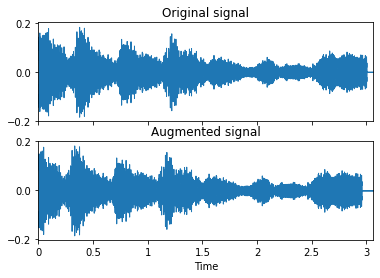

In [ ]:
_plot_signal_and_augmented_signal(data_train['seq_3_seconds'][1200], shift_dataset['seq_3_seconds'][1200], 22050)

**Noise injection**

The noise injection technique simply add some random value into data by sampling from a Standard normal distribution.

In [ ]:
# Noise injection
def add_noise(data, noise_factor):
  # We manipulate the sequence element-wise by summing random numbers sampled from a standard normal distribution
  # to generate random numbers from a N(0,1) we use the numpy method random.randn()
  noise = np.random.randn(len(data))
  # augmented data contains the new synthetic data
  # noise factor is a value that we use to decide the magnitude of the random noise that we add 
  augmented_data = data + noise_factor * noise 
  augmented_data = augmented_data.astype(type(data[0]))
  # Returns manipulated sequence
  return augmented_data

noise_data = [add_noise(seq, 0.009) for seq in data_train['seq_3_seconds']]

In [ ]:
# Create dataset containg songs with injected noise
noise_dataset = pd.DataFrame()
noise_dataset['label'] = data_train['label']
noise_dataset['seq_3_seconds'] = noise_data

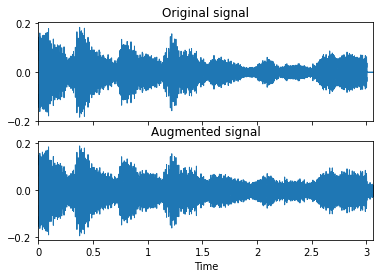

In [ ]:
_plot_signal_and_augmented_signal(data_train['seq_3_seconds'][1200], noise_dataset['seq_3_seconds'][1200], 22050)

In [ ]:
#ipd.Audio('audio/conga_groove.wav')

We concatenate the new generated synthetic data with the original train data, tripling the amount of data on which we will train our model.

In [ ]:
# data_augmented = (original, shifted data, noise data)
data_augmented = pd.concat([data_train, shift_dataset, noise_dataset], axis=0) 
data_augmented = data_augmented.reset_index(drop=True)
data_augmented

,label,seq_3_seconds
0,9,"[0.038085938, 0.0335083, 0.03286743, 0.0259094..."
1,5,"[-0.037017822, -0.04031372, -0.04034424, -0.04..."
2,9,"[-0.08798218, -0.08218384, -0.075286865, -0.07..."
3,6,"[-0.07485962, -0.03564453, 0.008331299, 0.0212..."
4,2,"[0.051849365, 0.05441284, 0.052612305, 0.06094..."
...,...,...
23995,9,"[-0.0306099, -0.044529386, -0.044998, -0.06576..."
23996,4,"[-0.3189678, -0.33760583, -0.3468993, -0.39289..."
23997,8,"[0.054824557, 0.018160123, -0.06536678, -0.109..."
23998,8,"[0.0017075028, 0.01320747, -0.0031393352, 0.00..."


# Extracting Mel-frequency cepstral coefficients (MFCCs)

In sound processing, the Mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. 

MFCCs are commonly derived as follows:

1. Take the Fourier transform of (a windowed excerpt of) a signal.
2. Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.
3. Take the logs of the powers at each of the mel frequencies.
4. Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
4. The MFCCs are the amplitudes of the resulting spectrum.

It has been demonstrated that for deep learning purposes this feature yields good results. 

We extract it for every track, resulting in a tensor of dimension [n of songs, mfcc sequence length, n of mfcc features].

In [ ]:
seq3_mfcc_train = []
for i in range(len(data_augmented['seq_3_seconds'])):
  # For each sequence (track) in the augmented dataset extracts mfcc features
    seq3_mfcc_train.append(
        # Store the extracted feature in a list
        lr.feature.mfcc(y = data_augmented['seq_3_seconds'][i])
        )
y_augmented = np.array(data_augmented['label'])
# Convert to numpy array in float32 dtype for torch compatibility
seq3_mfcc_train = np.array(seq3_mfcc_train, dtype='float32')

NameError: ignored

In [ ]:
seq3_mfcc_test = []
for i in range(len(data_test['seq_3_seconds'])):
  # For each sequence (track) in the augmented dataset extracts mfcc features
    seq3_mfcc_test.append(
        # Store the extracted feature in a list
        lr.feature.mfcc(y = data_test['seq_3_seconds'][i])
        )
#for later purposes we create a vector with all the category's labels
y_test = np.array(data_test['label'])
# Convert to numpy array in float32 dtype for torch compatibility
seq3_mfcc_test = np.array(seq3_mfcc_test, dtype='float32')

In [ ]:
# Reshape data in order to have mfcc features on columns 
seq3_mfcc_train = seq3_mfcc_train.reshape((-1, seq3_mfcc_train.shape[2], seq3_mfcc_train.shape[1]))
seq3_mfcc_test = seq3_mfcc_test.reshape((-1, seq3_mfcc_test.shape[2], seq3_mfcc_test.shape[1]))
print(f'Training MFCC shape: {seq3_mfcc_train.shape}, Testing MFCC shape: {seq3_mfcc_test.shape}')

We scale each MFCC column of each track to achieve zero mean and unitary variance. This will help the training process of the network.

In [ ]:
# For each sequence (song)
for seq in range(len(seq3_mfcc_train)):
  # For each mfcc feature of the sequence (we have 20 of them)
    for feature in range(len(seq3_mfcc_train[seq][0])):
        # Standardize the sequence
        feat = seq3_mfcc_train[feature]
        mean, std = np.mean(feat), np.std(feat)
        feat  = (feat-mean)/std
        seq3_mfcc_train[feature] = feat
# For each song store the pair [mfcc features, label] in a list
data_ready_train = [[seq3_mfcc_train[i], y_augmented[i]] for i in range(len(seq3_mfcc_train))]

# For each sequence (song)
for seq in range(len(seq3_mfcc_test)):
  # For each mfcc feature of the sequence (we have 20 of them)
    for feature in range(len(seq3_mfcc_test[seq][0])):
        # Standardize the sequence
        feat = seq3_mfcc_test[feature]
        mean, std = np.mean(feat), np.std(feat)
        feat  = (feat-mean)/std
        seq3_mfcc_test[feature] = feat
# For each track store the mfcc features matrix and target label pair in a list
data_ready_test = [[seq3_mfcc_test[i], y_test[i]] for i in range(len(seq3_mfcc_test))]

We finally save the pre-processed data

In [ ]:
with open('Processed_data/data_train', 'wb') as f: 
    pickle.dump(data_ready_train, f)
with open('Processed_data/data_test', 'wb') as f: 
    pickle.dump(data_ready_test, f)

**Please find the model implementation in the notebook "model.ipynb".**